# INFO371 Problem Set: Classification and k-Nearest Neighbors

## Instructions

* Please write clearly! Answer each question in a way that if the code chunks are removed from your document, the result are still readable!
* Discussing the solutions and getting help is all right, but you have to solve the problem your own. Do not copy-paste from others!
* Make sure you show your work!

---

## Introduction
In this assignment, we are going to be looking at the Wisconsin Breast Cancer Dataset (WBCD).
The dataset orginates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) and it contains
569 cases from November 1995.  

The data includes tumor diagnosis, with "M" meaning cancer (malignant) and "B" meaning no cancer (benign), and 10 features describing the physical properties of the cell nuclei from biopsy samples.  Each
feature is represented three times, once for mean, once for standard deviation, and once for the worst values.  More specifically, the variables are: 

* id -> case id
* Diagnosis -> (M = malignant, B = benign).  These are the labels or the part you normally predict . 
* ten real-valued features computed for each cell nucleus. For each feature the mean, standard error, and ''worst'' or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.  For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius. 
   
It contains the following features:
   * radius -> mean of distances from center to points on the
     perimeter
   * texture -> standard deviation of gray-scale values
   * perimeter
   * area
   * smoothness -> local variation in radius lengths
   * compactness -> $ perimeter^2 / area - 1.0$
   * concavity -> severity of concave portions of the contour
   * concpoints -> number of concave portions of the contour
   * symmetry
   * fracdim -> fractal dimension, $coastline\ approximation - 1$


Your task is to predict diagnosis (cancer or not cancer) based on this data, and our focus is to use $k$-NN and different metrics.

## Explore the data  and  Experimental Setup (13pt)

As the first step, explore the data and establish a baseline!

1. Load the data, Ignore id.


2. Create a table where you show ranges (min and max) for each variable.  You may include more statistics you consider useful. 



3. Randomly select 80% of the data and put this in a training dataset df, and place the remaining 20% in a testing dataset df. 



4. Using this test/train spilt, create a naive model -- i.e. a model that predicts every case to the majority category/label. What is the training vs testing accuracy of this model? Is this what you expected, and why?



5. Add code to measure the running time of your algorithm. How long does it take to predict labels for the test data? 

    Note: you can use python's time library to measure runtime!

In [38]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")


# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

#1
df = pd.read_csv("wdbc.csv.bz2").drop('id', axis = 1)
df.head(5)

,diagnosis,radius.mean,texture.mean,perimeter.mean,area.mean,smoothness.mean,compactness.mean,concavity.mean,concpoints.mean,symmetry.mean,...,radius.worst,texture.worst,perimeter.worst,area.worst,smoothness.worst,compactness.worst,concavity.worst,concpoints.worst,symmetry.worst,fracdim.worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [39]:
#2
#create a table of summary statistics
data = []

for i in range(1, 31):
    data.append([df.columns[i], df[df.columns[i]].min(), df[df.columns[i]].max(), np.mean(df[df.columns[i]]),
                np.std(df[df.columns[i]])])
 
print(tabulate(data, headers = ["Variable", "Min", "Max", "Mean", "Std"], tablefmt='orgtbl'))

| Variable          |         Min |        Max |         Mean |          Std |
|-------------------+-------------+------------+--------------+--------------|
| radius.mean       |   6.981     |   28.11    |  14.1273     |   3.52095    |
| texture.mean      |   9.71      |   39.28    |  19.2896     |   4.29725    |
| perimeter.mean    |  43.79      |  188.5     |  91.969      |  24.2776     |
| area.mean         | 143.5       | 2501       | 654.889      | 351.605      |
| smoothness.mean   |   0.05263   |    0.1634  |   0.0963603  |   0.0140518  |
| compactness.mean  |   0.01938   |    0.3454  |   0.104341   |   0.0527663  |
| concavity.mean    |   0         |    0.4268  |   0.0887993  |   0.0796497  |
| concpoints.mean   |   0         |    0.2012  |   0.0489191  |   0.0387687  |
| symmetry.mean     |   0.106     |    0.304   |   0.181162   |   0.0273902  |
| fracdim.mean      |   0.04996   |    0.09744 |   0.0627976  |   0.00705416 |
| radius.se         |   0.1115    |    2.873   |   0

In [40]:
#3
features = df.loc[:, ~df.columns.isin(['diagnosis'])] 
label = df.diagnosis
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.20)

In [41]:
#4, 5
st = time.time()

m = DummyClassifier(strategy = "most_frequent")
m.fit(X_train, y_train)
y_pred_test = m.predict(X_test)

et = time.time()

y_pred_train= m.predict(X_train)


print("Training accuracy: " + str(accuracy_score(y_train, y_pred_train)))
print("Testing accuracy: " + str(accuracy_score(y_test, y_pred_test)))
print()
print("Runtime : " + str(et - st))

Training accuracy: 0.6351648351648351
Testing accuracy: 0.5964912280701754

Runtime : 0.0


I expected this outcome due to the use of a naive model that lacks consideration of the actual data, genearlly leading to low accuracy.

## Compare Performance to k-NN (32pts)

Now that you have a baseline performance, your next task is to compare the performace using a k-NN model and the Mahalanobis distance function. For these experiments, make sure you use the same test/train split as you did for your baseline.    

6. Using the same test/train split as the naive model, create a 1-NN model with Mahalanobis distance metric the then report what is the training vs testing accuracy of this model. How much better did 1-NN do compared to the naive baseline? 


7. Add code to measure the running time of your algorithm. How long does it take to predict labels for the test data? 


8. Now repeat steps 6-7 (i.e. get training and testing accuracy of the model and the runtime) for k values from 2 to 15. 


9. Using those results, create two line charts: 1) comparing performance and 2) comparing runtime as you vary k. Your k values should be on the x axis, and your y axis should be accuracy or run time in seconds. 


10. Describe your observations from these experiments. For example, this about whether there are any trade-offs with chosing certain k values. Is there anything about the data/experiment/model that impacts performance in a good and bad way? How well did the k-nn model do compared to the naive baseline? 

In [42]:
#code goes here
#6, #7
def model(features, X_train, X_test, num):
    st = time.time()

    Sigma = np.cov(features, rowvar = False)
    m = KNeighborsClassifier(n_neighbors = num,
                             metric = "mahalanobis",
                             metric_params = {"VI": Sigma})
    m.fit(X_train, y_train)
    y_pred_test = m.predict(X_test)
    et = time.time()
    y_pred_train= m.predict(X_train)

    print("Training accuracy of Mahalanobis with k = " + str(num) + ": " +  str(accuracy_score(y_train, y_pred_train)))
    print("Testing accuracy of Mahalanobis with k = " + str(num) + ": "  +  str(accuracy_score(y_test, y_pred_test)))
    print("Runtime : " + str(et - st))
    print()
    
model(features, X_train, X_test, 1)

Training accuracy of Mahalanobis with k = 1: 1.0
Testing accuracy of Mahalanobis with k = 1: 0.8859649122807017
Runtime : 0.08295512199401855



The accuracy using 1-NN has improved compared to the naive baseline.

In [43]:
#8
for i in range(2, 16):
    model(features, X_train, X_test, i)

Training accuracy of Mahalanobis with k = 2: 0.9362637362637363
Testing accuracy of Mahalanobis with k = 2: 0.9122807017543859
Runtime : 0.07619094848632812

Training accuracy of Mahalanobis with k = 3: 0.9406593406593406
Testing accuracy of Mahalanobis with k = 3: 0.8947368421052632
Runtime : 0.06345176696777344

Training accuracy of Mahalanobis with k = 4: 0.9252747252747253
Testing accuracy of Mahalanobis with k = 4: 0.9035087719298246
Runtime : 0.03628349304199219

Training accuracy of Mahalanobis with k = 5: 0.9296703296703297
Testing accuracy of Mahalanobis with k = 5: 0.9035087719298246
Runtime : 0.10559439659118652

Training accuracy of Mahalanobis with k = 6: 0.9230769230769231
Testing accuracy of Mahalanobis with k = 6: 0.9122807017543859
Runtime : 0.03120565414428711

Training accuracy of Mahalanobis with k = 7: 0.9274725274725275
Testing accuracy of Mahalanobis with k = 7: 0.9122807017543859
Runtime : 0.08266615867614746

Training accuracy of Mahalanobis with k = 8: 0.92087

Average performance of testing/training: 0.9093567251461985, 0.9290842490842492
Average running time: 0.0686685562133789


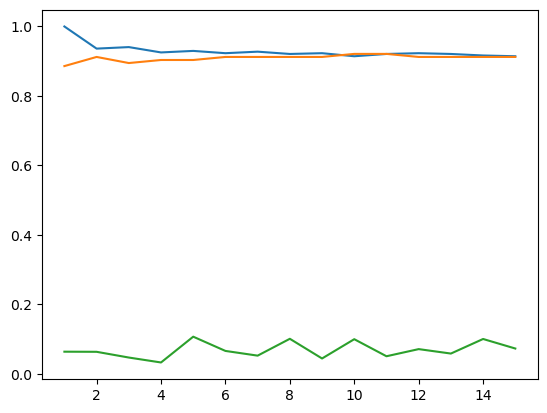

In [44]:
#9
def result(features, X_train, X_test, num):
    st = time.time()

    Sigma = np.cov(features, rowvar = False)
    m = KNeighborsClassifier(n_neighbors = num,
                             metric = "mahalanobis",
                             metric_params = {"VI": Sigma})
    m.fit(X_train, y_train)
    y_pred_test = m.predict(X_test)
    et = time.time()
    y_pred_train= m.predict(X_train)

    
    return ((et - st), accuracy_score(y_test, y_pred_test), accuracy_score(y_train, y_pred_train))

k = []
r_time = []
prf_test = []
prf_train = []
for i in range(1, 16):
    r_val, score_test, score_train = result(features, X_train, X_test, i)
    k.append(i)
    r_time.append(r_val)
    prf_test.append(score_test)
    prf_train.append(score_train)

print("Average performance of testing/training: " + str(np.mean(prf_test)) + ", " + str(np.mean(prf_train)))
print("Average running time: " + str(np.mean(r_time)))
plt.plot(k, prf_train)
plt.plot(k, prf_test)
plt.plot(k, r_time)

In [45]:
#10

The observation represents that as k value increases, the performance slightly increases and becomes more consistent between training and testing datasets.In terms of comparing results between two values of k, a slightly longer running time helps improve its performance. This is because the k determines the number of neighbors that will be checked, resulting in a significantly longer running time and helping the performance improved better. Therefore, the k-NN model performs better overall compared to the naive model.

## Feature Transformation (30pts)

As we talked about in class, normalizing your features can have a huge impact on k-nn model performance. When we ran the experiments above, we did not normalize our features! let's now examine how this might impact the model. 

11. Your first step is to write your own normalization function for this dataset and apply it to your training and testing data. Remeber that normalization typically takes in an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation). Note that you might already have these numbers in the dataset itself! 



12. With your features normalized, repeat the experiments you did earlier by doing the following: 
        a. Create a k-nn model with Mahalanobis distance metric
        b. run the model for all k-values between 1-15
        c. report the training and testing accuracy and the runtime 



13. Using those resilts, create two line charts: 1) comparing performance and 2) comparing runtime as you vary k. Your k values should be on the x axis, and your y axis should be accuracy or run time in seconds.



14. Now compare your performance between the normalized and non-normalized datasets. How much did normalization impact performance?  It might help to show both performances on the same line chart to really compare.

In [46]:
#code goes here 
#11
def nrmlz(X_train, X_test):
    num_mean = np.mean(X_train, axis=0)
    num_std = np.std(X_train, axis=0)

    X_train_new = (X_train - num_mean) / num_std
    X_test_new = (X_test - num_mean) / num_std

    return X_train_new, X_test_new
        
X_train, X_test = nrmlz(X_train, X_test)

In [47]:
#12    
for i in range(1, 16):
    model(features, X_train, X_test, i)

Training accuracy of Mahalanobis with k = 1: 1.0
Testing accuracy of Mahalanobis with k = 1: 0.9122807017543859
Runtime : 0.07281899452209473

Training accuracy of Mahalanobis with k = 2: 0.9362637362637363
Testing accuracy of Mahalanobis with k = 2: 0.8859649122807017
Runtime : 0.05485033988952637

Training accuracy of Mahalanobis with k = 3: 0.9406593406593406
Testing accuracy of Mahalanobis with k = 3: 0.9035087719298246
Runtime : 0.056799888610839844

Training accuracy of Mahalanobis with k = 4: 0.9318681318681319
Testing accuracy of Mahalanobis with k = 4: 0.8859649122807017
Runtime : 0.05377364158630371

Training accuracy of Mahalanobis with k = 5: 0.9274725274725275
Testing accuracy of Mahalanobis with k = 5: 0.9035087719298246
Runtime : 0.06880784034729004

Training accuracy of Mahalanobis with k = 6: 0.9252747252747253
Testing accuracy of Mahalanobis with k = 6: 0.9035087719298246
Runtime : 0.04935956001281738

Training accuracy of Mahalanobis with k = 7: 0.9296703296703297
Te

Average performance of testing/training: 0.9023391812865498, 0.9334798534798536
Average running time: 0.06021628379821777


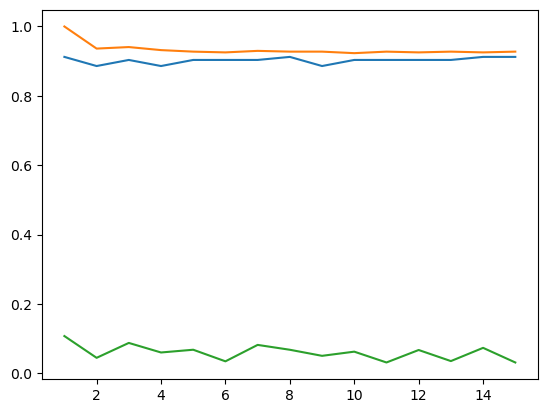

In [48]:
#13
k = []
r_time = []
prf_test = []
prf_train = []
for i in range(1, 16):
    r_val, score_test, score_train = result(features, X_train, X_test, i)
    k.append(i)
    r_time.append(r_val)
    prf_test.append(score_test)
    prf_train.append(score_train)

print("Average performance of testing/training: " + str(np.mean(prf_test)) + ", " + str(np.mean(prf_train)))
print("Average running time: " + str(np.mean(r_time)))
plt.plot(k, prf_test)
plt.plot(k, prf_train)
plt.plot(k, r_time)

In [49]:
#14

The testing accuracy of the normalized dataset remains the same, consistent accuracy compred to the non-normalized dataset. However, the running time has improved better compared to the non-normalized dataset.

## Cross-Validation (25pts)

Up until this point, all of our experiments have used the same test/train spilt. But that might not reflect average peformance. We could have, for example, gotten lucky and randomly chosen a test/train split that happened to improve performance. Instead, we want to get average performance over a number of data splits to get a better idea of how our model is working. 

To do this, we need to use cross-validation to get average performance. For our experiments, use 10-fold cross-validation sames as you did in lab. 

15. Repeat the experiments you did earlier on the normalized dataset by doing the following: 
        a. Create a k-nn model with Mahalanobis distance metric
        b. run the model with 10-fold cross validation for all k-values between 1-15
        c. report the average training and average testing accuracy and the average runtime for all k values 
      
      
16. Using those resilts, create two line charts: 1) comparing average performance and 2) comparing average runtime as you vary k. Your k values should be on the x axis, and your y axis should be accuracy or run time in seconds.



17. Describe your observations from these experiments. Did anything change when you did cross-validation? 

In [50]:
# code goes here 
#15
def cv_model(features, X_train, X_test, num):
    st = time.time()

    Sigma = np.cov(features, rowvar = False)
    m = KNeighborsClassifier(n_neighbors = num,
                             metric = "mahalanobis",
                             metric_params = {"VI": Sigma})
    m.fit(X_train, y_train)
    
    cv = cross_val_score(m, X_test, y_test, cv = 10)
    score_test = np.mean(cv)

    et = time.time()
    
    cv = cross_val_score(m, X_train, y_train, cv = 10)
    score_train = np.mean(cv)

    print("Training accuracy of Mahalanobis with k = " + str(num) + ": " +  str(score_train))
    print("Testing accuracy of Mahalanobis with k = " + str(num) + ": "  +  str(score_test))
    print("Runtime : " + str(et - st))
    print()
    
    return ((et - st), score_test, score_train)

k = []
r_time = []
prf_test = []
prf_train = []
for i in range(1, 16):
    r_val, score_test, score_train = cv_model(features, X_train, X_test, i)
    k.append(i)
    r_time.append(r_val)
    prf_test.append(score_test)
    prf_train.append(score_train)
   
print("Average performance of testing/training: " + str(np.mean(prf_test)) + ", " + str(np.mean(prf_train)))
print("Average running time: " + str(np.mean(r_time)))

Training accuracy of Mahalanobis with k = 1: 0.8946376811594202
Testing accuracy of Mahalanobis with k = 1: 0.8765151515151516
Runtime : 0.05572986602783203

Training accuracy of Mahalanobis with k = 2: 0.8968599033816425
Testing accuracy of Mahalanobis with k = 2: 0.8772727272727273
Runtime : 0.07468581199645996

Training accuracy of Mahalanobis with k = 3: 0.9080193236714976
Testing accuracy of Mahalanobis with k = 3: 0.85
Runtime : 0.047209978103637695

Training accuracy of Mahalanobis with k = 4: 0.9102415458937199
Testing accuracy of Mahalanobis with k = 4: 0.8681818181818182
Runtime : 0.09694838523864746

Training accuracy of Mahalanobis with k = 5: 0.9146859903381642
Testing accuracy of Mahalanobis with k = 5: 0.8863636363636364
Runtime : 0.06490802764892578

Training accuracy of Mahalanobis with k = 6: 0.9233816425120773
Testing accuracy of Mahalanobis with k = 6: 0.8863636363636364
Runtime : 0.06691312789916992

Training accuracy of Mahalanobis with k = 7: 0.9233816425120773
T

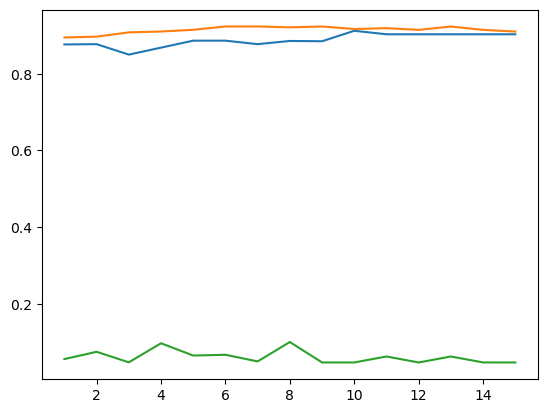

In [51]:
#15, 16
plt.plot(k, prf_test)
plt.plot(k, prf_train)
plt.plot(k, r_time)

In [52]:
#17

The testing accuracy slightly decreased and the running time worsened when using cross-validation. I assume that the longer running time was a result of adding the additional fold function to calculate the score.

## Extra Credit (+10 pts)

For extra credit, repeat the cross-validation experiments (i.e. varying the k-values) on the normalized dataset BUT this time compare performance and runtime between all 4 distance metrics you used in lab. Then analyze your results and discuss the benefits/trade-offs for each of the metrics for this dataset. 

In [53]:
def model(name, num):
    st = time.time()
    if (name == "Mahalanobis"):
        Sigma = np.cov(features, rowvar=False)
        m = KNeighborsClassifier(n_neighbors = num,
                                 metric = "mahalanobis",
                                 metric_params = {"VI": Sigma})
    else:
        m = KNeighborsClassifier(metric = name.lower(), n_neighbors = num)
    
    m.fit(X_train, y_train)
    cv = cross_val_score(m, X_test, y_test, cv = 10)
    print("Testing Score of " + name + " with k = " + str(num)+ ": " +  str(np.mean(cv)))
    
    et = time.time()
        
    cv = cross_val_score(m, X_train, y_train, cv = 10)
    print("Training Score of " + name + " with k = " + str(num)+ ": " +  str(np.mean(cv)))
    print("Runtime : " + str(et - st))
    print()
    
metrics = ["Euclidean", "Manhattan", "Chebyshev", "Mahalanobis"]

for i in range(0, 4):
    for k in range(1, 16):
        model(metrics[i], k)
    print()

Testing Score of Euclidean with k = 1: 0.9227272727272726
Training Score of Euclidean with k = 1: 0.9517874396135266
Runtime : 0.08513450622558594

Testing Score of Euclidean with k = 2: 0.8871212121212121
Training Score of Euclidean with k = 2: 0.9582125603864734
Runtime : 0.09117889404296875

Testing Score of Euclidean with k = 3: 0.9492424242424242
Training Score of Euclidean with k = 3: 0.9670048309178745
Runtime : 0.0670320987701416

Testing Score of Euclidean with k = 4: 0.95
Training Score of Euclidean with k = 4: 0.96256038647343
Runtime : 0.049695730209350586

Testing Score of Euclidean with k = 5: 0.9583333333333333
Training Score of Euclidean with k = 5: 0.9647826086956522
Runtime : 0.04427528381347656

Testing Score of Euclidean with k = 6: 0.940909090909091
Training Score of Euclidean with k = 6: 0.962657004830918
Runtime : 0.07124996185302734

Testing Score of Euclidean with k = 7: 0.940909090909091
Training Score of Euclidean with k = 7: 0.9692270531400966
Runtime : 0.08

Training Score of Mahalanobis with k = 11: 0.9189371980676329
Runtime : 0.07850003242492676

Testing Score of Mahalanobis with k = 12: 0.903030303030303
Training Score of Mahalanobis with k = 12: 0.9145410628019324
Runtime : 0.04687070846557617

Testing Score of Mahalanobis with k = 13: 0.903030303030303
Training Score of Mahalanobis with k = 13: 0.9232850241545894
Runtime : 0.10173773765563965

Testing Score of Mahalanobis with k = 14: 0.903030303030303
Training Score of Mahalanobis with k = 14: 0.9145410628019324
Runtime : 0.07917404174804688

Testing Score of Mahalanobis with k = 15: 0.903030303030303
Training Score of Mahalanobis with k = 15: 0.9101932367149759
Runtime : 0.04619717597961426




- Euclidean: It produces significantly high overall performance but takes longer than Manhattan and Chebyshev models. One benefit of this distance metric is that it generalizes well which can be used in a wide range of applications. However, its performance could be affected by some outliers if the data was not normalized enough.
- Manhattan: It produces the highest overall performance among all 4 distance metrics. One benefit of this distance metric is that it is not quite sensitive to outliers which generates consistent performance in the dataset. However, it assumes that all features are equally significant, which may not be suitable for this dataset.
- Chebyshev: It results in the shortest running time. Its benefit is that it is also not quite sensitive to outliers, resulting in high, consistent performances in this dataset. However, it may not reflect true distances between vectors, especially when they are significantly far apart in non-normalized dataset.
- Mahalanobis: It produces the lowest overall performance among all 4 distance metrics. Considering the covariance between variables, it actually allows a more distance between vectors. However, in this dataset, it assumes a normalized dataset, which may also not be suitable for this dataset.